# 05_ANOMALY DETECTION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

## 1. LOAD DATA

In [2]:
df = pd.read_csv("cleaned_data.csv")
print("Shape:", df.shape)

Shape: (3900, 28)


## 2. FEATURE SELECTION

In [3]:
features = [
    "Purchase Amount (USD)",
    "Previous Purchases",
    "RFM_Score",
    "Discount_Sensitivity",
    "Review Rating"
]

X = df[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features used:", features)

Features used: ['Purchase Amount (USD)', 'Previous Purchases', 'RFM_Score', 'Discount_Sensitivity', 'Review Rating']


In [4]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA Explained Variance: {pca.explained_variance_ratio_.sum():.2%}")

PCA Explained Variance: 57.35%


## 3. ISOLATION FOREST (Global Anomalies)

In [5]:
iso = IsolationForest(
    contamination=0.05,
    n_estimators=300,
    random_state=42
)

df["IF_Label"] = iso.fit_predict(X_scaled)
df["IF_Score"] = iso.decision_function(X_scaled)
df["IF_Anomaly"] = (df["IF_Label"] == -1).astype(int)

df["IF_Severity"] = (
    df["IF_Score"].max() - df["IF_Score"]
) / (df["IF_Score"].max() - df["IF_Score"].min())

print("Isolation Forest flagged:", df["IF_Anomaly"].sum())

Isolation Forest flagged: 195


## 4. LOCAL OUTLIER FACTOR (Relative Anomalies)

In [6]:
lof = LocalOutlierFactor(
    n_neighbors=25,
    contamination=0.05
)

df["LOF_Label"] = lof.fit_predict(X_scaled)
df["LOF_Score"] = -lof.negative_outlier_factor_
df["LOF_Anomaly"] = (df["LOF_Label"] == -1).astype(int)

df["LOF_Severity"] = (
    df["LOF_Score"] - df["LOF_Score"].min()
) / (df["LOF_Score"].max() - df["LOF_Score"].min())

print("LOF flagged:", df["LOF_Anomaly"].sum())

LOF flagged: 195


## 5. COMBINED FLAG

In [7]:
df["Is_Anomaly"] = (
    (df["IF_Anomaly"] == 1) |
    (df["LOF_Anomaly"] == 1)
).astype(int)

df["Anomaly_Confidence"] = (
    df["IF_Anomaly"] +
    df["LOF_Anomaly"]
)

df["Anomaly_Severity"] = (
    df["IF_Severity"] +
    df["LOF_Severity"]
) / 2

print("Total flagged:", df["Is_Anomaly"].sum())

Total flagged: 325


## 6. SMART THRESHOLDS

In [8]:
spend_90 = df["Purchase Amount (USD)"].quantile(0.90)
spend_95 = df["Purchase Amount (USD)"].quantile(0.95)
purchases_90 = df["Previous Purchases"].quantile(0.90)

## 7. ANOMALY TYPE TAGGING

In [9]:
df["Anomaly_Type"] = "Normal"

mask = df["Is_Anomaly"] == 1

df.loc[
    mask &
    (df["Purchase Amount (USD)"] > spend_95) &
    (df["RFM_Score"] >= df["RFM_Score"].quantile(0.90)),
    "Anomaly_Type"
] = "VIP Ultra-Spender"

df.loc[
    mask &
    (df["Discount_Sensitivity"] > 0.8) &
    (df["Review Rating"] < 3),
    "Anomaly_Type"
] = "Discount Abuser"

df.loc[
    mask &
    (df["Previous Purchases"] <= 5) &
    (df["RFM_Score"] < df["RFM_Score"].quantile(0.25)),
    "Anomaly_Type"
] = "Churn-Risk Ghost"

df.loc[
    mask &
    (df["Previous Purchases"] > purchases_90) &
    (df["Purchase Amount (USD)"] > spend_90),
    "Anomaly_Type"
] = "Suspicious Bulk Buyer"

df.loc[
    mask &
    (df["Anomaly_Type"] == "Normal"),
    "Anomaly_Type"
] = "Unusual Behavior"

print("\nAnomaly Type Distribution:")
print(df[df["Is_Anomaly"] == 1]["Anomaly_Type"].value_counts())


Anomaly Type Distribution:
Anomaly_Type
Unusual Behavior         191
Churn-Risk Ghost          55
Discount Abuser           53
Suspicious Bulk Buyer     14
VIP Ultra-Spender         12
Name: count, dtype: int64


## 8. GENAI-READY EXPLANATIONS

In [10]:
explanations = {
    "VIP Ultra-Spender":
        "Extremely high spend and loyalty. Target for premium retention.",
    "Discount Abuser":
        "High discount usage with weak satisfaction. Monitor margin risk.",
    "Churn-Risk Ghost":
        "Low engagement and declining activity. Trigger win-back campaign.",
    "Suspicious Bulk Buyer":
        "Unusually high purchase frequency and spend. Review for resale risk.",
    "Unusual Behavior":
        "Behavior deviates significantly from peer group."
}

df["Anomaly_Explanation"] = df["Anomaly_Type"].map(explanations)

## 9. VISUALIZATION

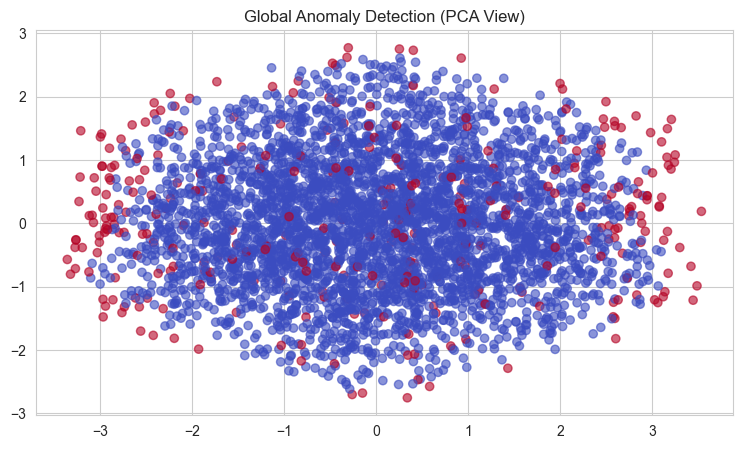

In [11]:
plt.figure(figsize=(9, 5))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=df["Is_Anomaly"],
    cmap="coolwarm",
    alpha=0.6
)
plt.title("Global Anomaly Detection (PCA View)")
plt.show()

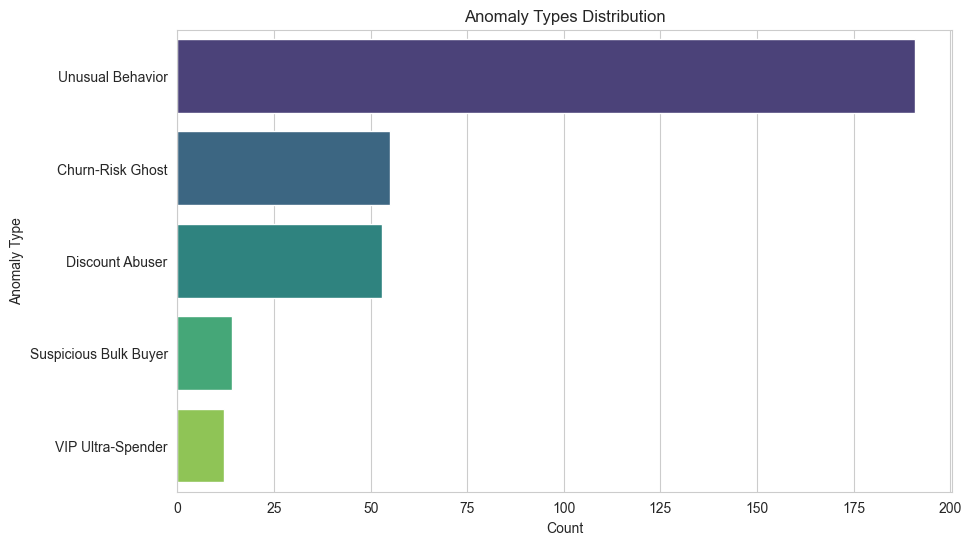

In [12]:
plt.figure(figsize=(10, 6))
anomaly_counts = df[df["Is_Anomaly"] == 1]["Anomaly_Type"].value_counts()
sns.barplot(x=anomaly_counts.values, y=anomaly_counts.index, palette="viridis")
plt.title("Anomaly Types Distribution")
plt.xlabel("Count")
plt.ylabel("Anomaly Type")
plt.show()

## 10. FLAGGED CUSTOMERS TABLE

In [13]:
flagged_cols = ["Customer ID", "Anomaly_Type", "Anomaly_Confidence", "Anomaly_Severity",
                 "Purchase Amount (USD)", "Previous Purchases", "RFM_Score", "Discount_Sensitivity"]

flagged = df[df["Is_Anomaly"] == 1][flagged_cols].sort_values("Anomaly_Severity", ascending=False)

print("\nTop Flagged Customers:")
print(flagged.head(10))


Top Flagged Customers:
      Customer ID           Anomaly_Type  Anomaly_Confidence  \
992           993  Suspicious Bulk Buyer                   2   
586           587       Unusual Behavior                   2   
1109         1110       Unusual Behavior                   2   
1068         1069  Suspicious Bulk Buyer                   2   
1253         1254       Unusual Behavior                   2   
3581         3582  Suspicious Bulk Buyer                   2   
1264         1265        Discount Abuser                   2   
248           249      VIP Ultra-Spender                   2   
2831         2832       Unusual Behavior                   1   
768           769        Discount Abuser                   2   

      Anomaly_Severity  Purchase Amount (USD)  Previous Purchases  RFM_Score  \
992           0.984346                     99                  50         15   
586           0.894856                     20                   9          3   
1109          0.878305         

## 11. SUMMARY

In [14]:
print("ANOMALY DETECTION SUMMARY\n")
print(f"Isolation Forest Anomalies: {df['IF_Anomaly'].sum()}")
print(f"LOF Anomalies: {df['LOF_Anomaly'].sum()}")
print(f"Total Flagged: {df['Is_Anomaly'].sum()}")
print("\nAnomaly Type Breakdown:")
print(df[df["Is_Anomaly"] == 1]["Anomaly_Type"].value_counts())


ANOMALY DETECTION SUMMARY

Isolation Forest Anomalies: 195
LOF Anomalies: 195
Total Flagged: 325

Anomaly Type Breakdown:
Anomaly_Type
Unusual Behavior         191
Churn-Risk Ghost          55
Discount Abuser           53
Suspicious Bulk Buyer     14
VIP Ultra-Spender         12
Name: count, dtype: int64
